In [6]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque


In [7]:
class QuantileNetwork(nn.Module):
    def __init__(self, state_size, action_size, num_quantiles):
        super(QuantileNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size * num_quantiles)
        self.action_size = action_size
        self.num_quantiles = num_quantiles

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        quantiles = x.view(-1, self.action_size, self.num_quantiles)
        return quantiles


In [8]:
class Agent:
    def __init__(self, state_size, action_size, num_quantiles, gamma, lr, batch_size, buffer_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.num_quantiles = num_quantiles
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.device = device

        self.q_network = QuantileNetwork(state_size, action_size, num_quantiles).to(self.device)
        self.target_network = QuantileNetwork(state_size, action_size, num_quantiles).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        self.update_target_network()
        
        # Initialize taus
        self.taus = torch.arange(0.5 / self.num_quantiles, 1.0, 1.0 / self.num_quantiles).to(self.device)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state, epsilon=0.1):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                quantiles = self.q_network(state)
                q_values = quantiles.mean(dim=2)
                action = q_values.max(1)[1].item()
        else:
            action = random.choice(np.arange(self.action_size))
        return action

    def step(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.batch_size:
            self.learn()

    def learn(self):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.memory, self.batch_size))
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Get target quantiles
        with torch.no_grad():
            next_quantiles = self.target_network(next_states)
            next_q_values = next_quantiles.mean(dim=2)
            next_actions = next_q_values.max(1)[1].unsqueeze(1).unsqueeze(1).expand(self.batch_size, 1, self.num_quantiles)
            next_best_quantiles = next_quantiles.gather(1, next_actions).squeeze(1)
            target_quantiles = rewards.unsqueeze(1) + (self.gamma * next_best_quantiles * (1 - dones.unsqueeze(1)))

        # Get current quantiles
        quantiles = self.q_network(states)
        actions = actions.unsqueeze(1).unsqueeze(1).expand(self.batch_size, 1, self.num_quantiles)
        current_quantiles = quantiles.gather(1, actions).squeeze(1)

        # Ensure non-decreasing quantiles
        current_quantiles = torch.sort(current_quantiles, dim=1)[0]

        # Compute quantile regression loss
        td_errors = target_quantiles.unsqueeze(2) - current_quantiles.unsqueeze(1)
        huber_loss = 0.5 * td_errors.pow(2) * (td_errors.abs() <= 1.0).float() + (td_errors.abs() - 0.5) * (td_errors.abs() > 1.0).float()
        quantile_loss = torch.abs(self.taus.unsqueeze(0).unsqueeze(0) - (td_errors < 0).float()) * huber_loss
        loss = quantile_loss.sum(dim=1).mean(dim=1).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save(self, filename):
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, filename)

    def load(self, filename):
        checkpoint = torch.load(filename, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.q_network.to(self.device)
        self.target_network.to(self.device)


In [9]:
def train_agent(num_episodes,rewards, save_path=None, load_path=None, device='cpu'):
    env = gym.make('LunarLander-v2')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    num_quantiles = 51
    gamma = 0.99
    lr = 0.001
    batch_size = 64
    buffer_size = 100000
    device = torch.device(device)

    agent = Agent(state_size, action_size, num_quantiles, gamma, lr, batch_size, buffer_size, device)
    
    if load_path:
        agent.load(load_path)
        print(f"Loaded model from {load_path}")

    for e in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
        agent.update_target_network()
        rewards.append(total_reward)
        print(f"Episode {e+1}/{num_episodes}, Total Reward: {total_reward}")
        
        if save_path and (e + 1) % 100 == 0:
            agent.save(save_path)
            print(f"Saved model to {save_path}")
        
        if num_episodes > 100 and sum(rewards[-20:])>5000:
            print("Solved")
            agent.save(save_path)
            print(f"Saved model to {save_path}")
            break



In [10]:
rewards = []
train_agent(1000,rewards, save_path='nqfn_lunar_lander.pth', device='cuda' if torch.cuda.is_available() else 'cpu')


/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/janak/Documents/Pytorch_CPU/venv/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1/1000, Total Reward: -408.05809231297553
Episode 2/1000, Total Reward: -307.91305814016357
Episode 3/1000, Total Reward: -143.56444339055963
Episode 4/1000, Total Reward: -111.13868339563564
Episode 5/1000, Total Reward: -162.83049073497028
Episode 6/1000, Total Reward: -341.0511843959455
Episode 7/1000, Total Reward: -283.77563007847857
Episode 8/1000, Total Reward: -207.32290447058966
Episode 9/1000, Total Reward: -162.91990317084938
Episode 10/1000, Total Reward: -198.56870386910424
Episode 11/1000, Total Reward: 6.98419951192264
Episode 12/1000, Total Reward: -69.75350225037096
Episode 13/1000, Total Reward: -181.61634321116944
Episode 14/1000, Total Reward: 17.052748574949273
Episode 15/1000, Total Reward: -102.3167749076636
Episode 16/1000, Total Reward: -125.0784124357371
Episode 17/1000, Total Reward: -205.23533096647748
Episode 18/1000, Total Reward: -203.6990750660782
Episode 19/1000, Total Reward: -112.07224210944055
Episode 20/1000, Total Reward: -86.81675960969177

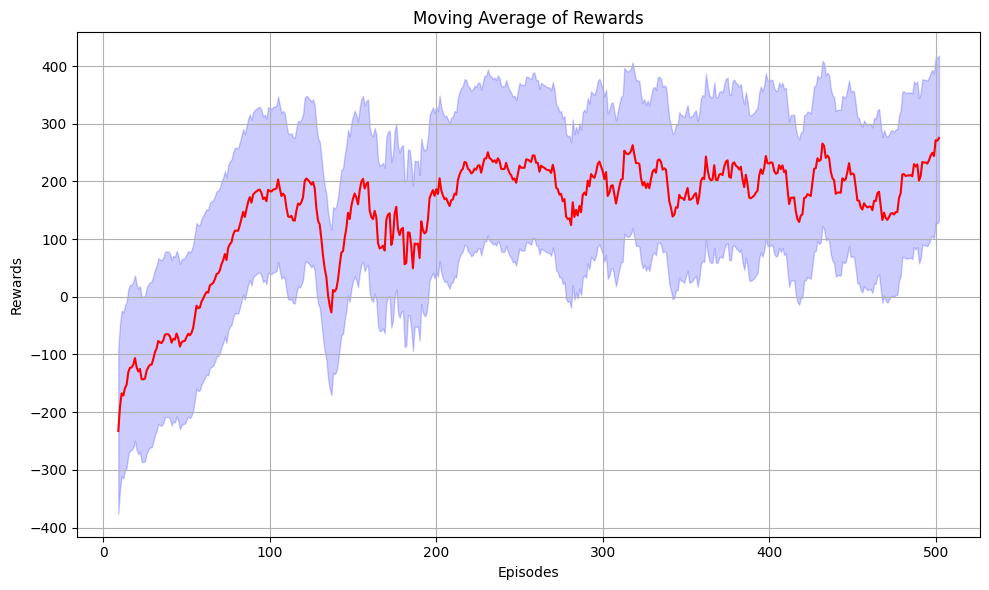

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some sample data
np.random.seed(0)
data = rewards

# Calculate the moving average
window_size = 10
moving_avg = pd.Series(data).rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot the moving average line
sns.lineplot(data=moving_avg, color='red')

# Shade the area around the moving average line to represent the range of values
plt.fill_between(range(len(moving_avg)),
                 moving_avg - np.std(data),
                 moving_avg + np.std(data),
                 color='blue', alpha=0.2)

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Moving Average of Rewards')
plt.grid(True)
# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('Episode_rewards.png')
# Show the plot
plt.show()